## Explore Inspections & Parcel Data

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

sys.path.append("../utils")

import config

pd.set_option("display.max_columns", None)

### Import SB County parcel boundaries

Data was obtained [here](https://databasin.org/datasets/008da0ba3dc14be18aa3bcfd90dc9615/).

In [4]:
# Read in parcel data
gbd_path = os.path.join(config.data_dir, "parcel_boundaries", "cbiinputs.gdb")
parcels = gpd.read_file(gbd_path)
parcels = parcels.to_crs(config.geodetic_crs)
print("Parcels CRS:", parcels.crs)

Parcels CRS: EPSG:4326


<Axes: >

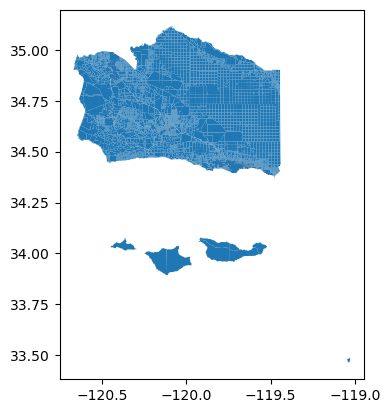

In [5]:
# Plot complete parcels file
parcels.plot()

### Explore parcel data

Parcel areas seem to vary widely across the county. 

Text(0, 0.5, 'Frequency')

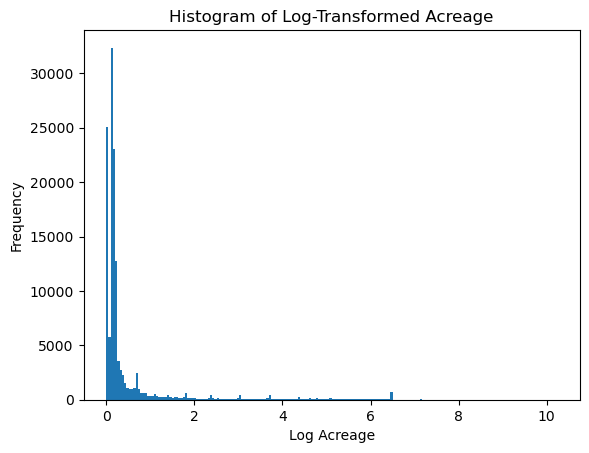

In [6]:
# Parcel area plot
parcels["log_acreage"] = np.log(parcels.acreage + 1)
parcels.log_acreage.plot.hist(bins=200)
plt.title("Histogram of Log-Transformed Acreage")
plt.xlabel("Log Acreage")
plt.ylabel("Frequency")

## Inspections  data

### 2022 inspections

In [7]:
# Import 2022 inspections
inspection_2022_fp = os.path.join(
    config.data_dir,
    "inspections_data",
    "2022_defensible_space_inspections_SBC",
    "2022_defensible_space_inspections_SBC.shp",
)

inspection_2022 = gpd.read_file(inspection_2022_fp)

In [8]:
# Check compliance status counts
inspection_2022["status"].value_counts()

status
Compliant                                        13478
Uninspected (Locked Gate)                          776
Due for Inspection                                 290
Compliant 6 months - 1 year                        104
Incomplete Data or Never Inspected                  70
1st Non Compliant                                   56
Structure Destroyed                                 11
3rd Non Compliant                                    3
2nd Non Compliant                                    1
AB-38 Request (please complete within 5 days)        1
Name: count, dtype: int64

In [9]:
# Simplify categories
status_map = {
    "Compliant": "Compliant",
    "Compliant 6 months - 1 year": "Compliant",
    "1st Non Compliant": "Non-Compliant",
    "2nd Non Compliant": "Non-Compliant",
    "3rd Non Compliant": "Non-Compliant",
    "Uninspected (Locked Gate)": "Other",
    "Due for Inspection": "Other",
    "Incomplete Data or Never Inspected": "Other",
    "Structure Destroyed": "Other",
    "AB-38 Request (please complete within 5 days)": "Other",
}

inspection_2022["status"] = inspection_2022["status"].map(status_map)

# Check the new categories
print(inspection_2022["status"].value_counts())

# Remove `other` observations
status_other = inspection_2022["status"] == "Other"
inspection_2022 = inspection_2022[~status_other]

# Check the simplified status counts
print(f"\nSimplified status counts: \n{inspection_2022["status"].value_counts()}")

status
Compliant        13582
Other             1148
Non-Compliant       60
Name: count, dtype: int64

Simplified status counts: 
status
Compliant        13582
Non-Compliant       60
Name: count, dtype: int64


In [10]:
# Check different structure types inspected
print(f"Compliant Structures: {inspection_2022.loc[inspection_2022["status"] == "Compliant", "structuret"].value_counts()}")
print(f"\nNon-Compliant Structures: {inspection_2022.loc[inspection_2022["status"] == "Non-Compliant", "structuret"].value_counts()}")

Compliant Structures: structuret
Single Family Residence Single Story             8706
Single Family Residence Multi Story              2967
Utility or Miscellaneous Structure > 120 sqft    1084
Commercial Building Single Story                  240
Mobile Home Double Wide                           139
Multi Family Residence Multi Story                110
Commercial Building Multi Story                    78
Mobile Home Single Wide                            72
Multi Family Residence Single Story                71
Mixed Commercial/Residential                       33
Church                                             22
Infrastructure (Essential Services)                20
School                                             18
Mobile Home Triple Wide                            12
Motor Home (if used as a residence)                10
Name: count, dtype: int64

Non-Compliant Structures: structuret
Single Family Residence Single Story             25
Single Family Residence Multi Story      

In [11]:
# Join the parcel data to the inspections data
parcels = parcels.to_crs(inspection_2022.crs)
joined_2022 = gpd.sjoin(parcels, inspection_2022, how="inner", predicate="contains")


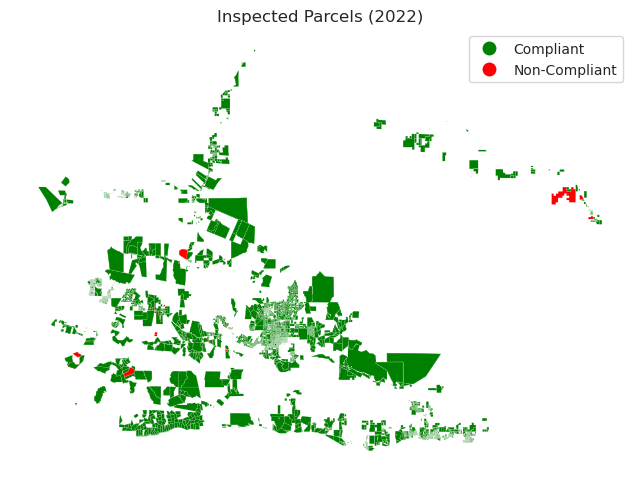

In [12]:
# Set seaborn style
sns.set_style("white")

# Create custom colormap
cmap = colors.ListedColormap(["green", "red"])

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the plot
joined_2022.plot(
    column="status",
    ax=ax,
    legend=True,
    cmap=cmap,
    linewidth=0.1,
    legend_kwds={"labels": ["Compliant", "Non-Compliant"]},
)

# Add labels and legend
plt.title("Inspected Parcels (2022)")
ax.axis("off")
plt.show()

#### Save 2022 joined data

located in "data/joined_inspections_parcels"

In [13]:
# Save the joined data to file
joined_2022_path = os.path.join(
    config.data_dir, "joined_inspections_parcels", "joined_2022.geojson"
)
joined_2022.to_file(joined_2022_path, driver="GeoJSON")

### 2018 inspections

In [14]:
# 2018 inspection data
inspection_2018_fp = os.path.join(
    config.data_dir,
    "inspections_data",
    "2018_defensible_space_inspections_SBC",
    "20181231_defensible_space_inspections_SBC.shp",
)

inspection_2018 = gpd.read_file(inspection_2018_fp)

# Check status counts
inspection_2018["status"].value_counts()

status
Incomplete Data or Never Inspected    9404
Due for 2019 Inspection               5763
Not Inspected Since 2017                 1
Name: count, dtype: int64

There appears to be no compliance status labels for the 2018 data.

### 2019 inspections

In [15]:
# Import 2019 inspections
inspection_2019_fp = os.path.join(
    config.data_dir,
    "inspections_data",
    "2019_defensible_space_inspections_SBC",
    "2019_defensible_space_inspections_SBC.shp",
)
inspection_2019 = gpd.read_file(inspection_2019_fp)
inspection_2019.head()

# Check status counts
print(inspection_2019["status"].value_counts())

# Simplify status categories
status_map_2019 = {
    "1st Compliant": "Compliant",
    "2nd Compliant": "Compliant",
    "3rd Compliant": "Compliant",
    "1st Non Compliant": "Non-Compliant",
    "2nd Non Compliant": "Non-Compliant",
    "3rd Non Compliant": "Non-Compliant",
    "Incomplete Data or Never Inspected": "Other",
    "Uninspected (Locked Gate)": "Other",
    "Structure Destroyed": "Other",
    "Due for 2019 Inspection": "Other",
}
inspection_2019["status"] = inspection_2019["status"].map(status_map_2019)

# Remove `other` observations
status_other = inspection_2019["status"] == "Other"
inspection_2019 = inspection_2019[~status_other]

# Check the simplified status counts
print(f"\nSimplified 2019 status counts: \n{inspection_2019["status"].value_counts()}")

status
1st Compliant                         14420
Incomplete Data or Never Inspected     1734
Uninspected (Locked Gate)               524
2nd Compliant                           130
1st Non Compliant                        70
2nd Non Compliant                        45
Structure Destroyed                      32
Due for 2019 Inspection                  22
3rd Non Compliant                         8
3rd Compliant                             2
Name: count, dtype: int64

Simplified 2019 status counts: 
status
Compliant        14552
Non-Compliant      123
Name: count, dtype: int64


In [16]:
# Check different structure types inspected
print(f"Compliant Structures: {inspection_2019.loc[inspection_2019["status"] == "Compliant", "structuret"].value_counts()}")
print(f"\nNon-Compliant Structures: {inspection_2019.loc[inspection_2019["status"] == "Non-Compliant", "structuret"].value_counts()}")

Compliant Structures: structuret
Single Family Residence Single Story             9093
Single Family Residence Multi Story              3202
Utility or Miscellaneous Structure > 120 sqft    1169
Commercial Building Single Story                  261
Mobile Home Double Wide                           160
Multi Family Residence Multi Story                108
Commercial Building Multi Story                    80
Mobile Home Single Wide                            77
Multi Family Residence Single Story                74
Infrastructure (Essential Services)                33
Mixed Commercial/Residential                       32
Church                                             23
Motor Home (if used as a residence)                21
School                                             17
Mobile Home Triple Wide                            11
Unable to Assess                                    7
Name: count, dtype: int64

Non-Compliant Structures: structuret
Single Family Residence Single Story   

In [17]:
# Join 2019 inspections to parcels
parcels = parcels.to_crs(inspection_2019.crs)
joined_2019 = gpd.sjoin(parcels, inspection_2019, how="inner", predicate="contains")

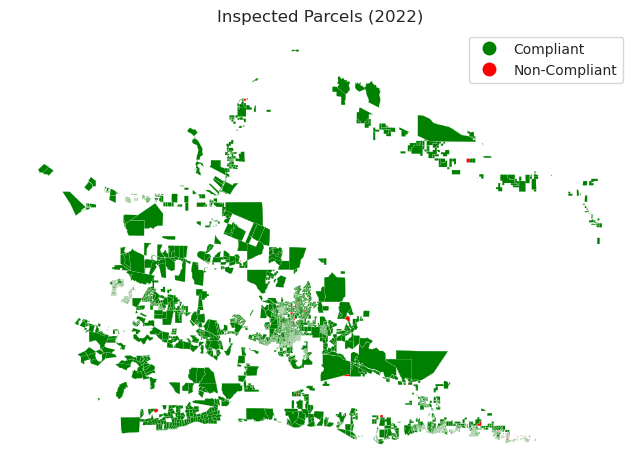

In [18]:
# Set seaborn style
sns.set_style("white")

# Create custom colormap
cmap = colors.ListedColormap(["green", "red"])

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the plot
joined_2019.plot(
    column="status",
    ax=ax,
    legend=True,
    cmap=cmap,
    linewidth=0.1,
    legend_kwds={"labels": ["Compliant", "Non-Compliant"]},
)

# Add labels and legend
plt.title("Inspected Parcels (2022)")
ax.axis("off")
plt.show()

### 2020 inspections data

In [19]:
# 2020 inspection data
inspection_2020_fp = os.path.join(
    config.data_dir,
    "inspections_data",
    "2020_defensible_space_inspections_SBC",
    "2020_defensible_space_inspections_SBC.shp",
)

inspection_2020 = gpd.read_file(inspection_2020_fp)
inspection_2020.head()

print(inspection_2020["status"].value_counts())

status_map_2020 = {
    "Compliant": "Compliant",
    "1st Non Compliant": "Non-Compliant",
    "2nd Non Compliant": "Non-Compliant",
    "Citation": "Non-Compliant",
    "Due for Inspection 2020": "Other",
    "Uninspected (Locked Gate)": "Other",
    "Incomplete Data or Never Inspected": "Other",
    "Structure Destroyed": "Other",
}

inspection_2020["status_simplified"] = inspection_2020["status"].map(status_map_2020)

print(inspection_2020["status_simplified"].value_counts())

status
Compliant                             11784
Due for Inspection 2020                2162
Uninspected (Locked Gate)               562
Incomplete Data or Never Inspected      120
1st Non Compliant                        91
Structure Destroyed                      47
2nd Non Compliant                         2
Citation                                  1
Name: count, dtype: int64
status_simplified
Compliant        11784
Other             2891
Non-Compliant       94
Name: count, dtype: int64


### 2021 inspections data

In [20]:
# 2021 inspection data
inspection_2021_fp = os.path.join(
    config.data_dir,
    "inspections_data",
    "2021_defensible_space_inspections_SBC",
    "2021_defensible_space_inspections_SBC.shp",
)

inspection_2021 = gpd.read_file(inspection_2021_fp)
inspection_2021.head()

print(inspection_2021["status"].value_counts())

status_map_2021 = {
    "Compliant": "Compliant",
    "1st Non Compliant": "Non-Compliant",
    "3rd Non Compliant": "Non-Compliant",
    "Due for Inspection 2021": "Other",
    "Uninspected (Locked Gate)": "Other",
    "Incomplete Data or Never Inspected": "Other",
    "Structure Destroyed": "Other",
}

inspection_2021["status_simplified"] = inspection_2021["status"].map(status_map_2021)

print(inspection_2021["status_simplified"].value_counts())

status
Compliant                             13942
Due for Inspection 2021                 306
Uninspected (Locked Gate)               299
Incomplete Data or Never Inspected      190
1st Non Compliant                        69
Structure Destroyed                       9
3rd Non Compliant                         1
Name: count, dtype: int64
status_simplified
Compliant        13942
Other              804
Non-Compliant       70
Name: count, dtype: int64


### 2023 inspections data

### Parcel sizes

#### 2022

In [21]:
# joined_2022.columns.to_list()

<Axes: ylabel='Frequency'>

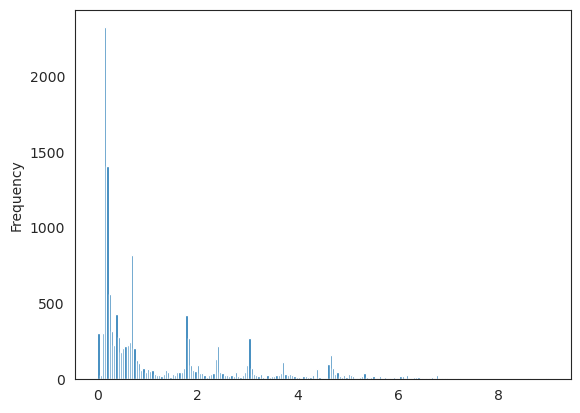

In [22]:
joined_2022.log_acreage.plot.hist(bins=200)

<Axes: ylabel='Frequency'>

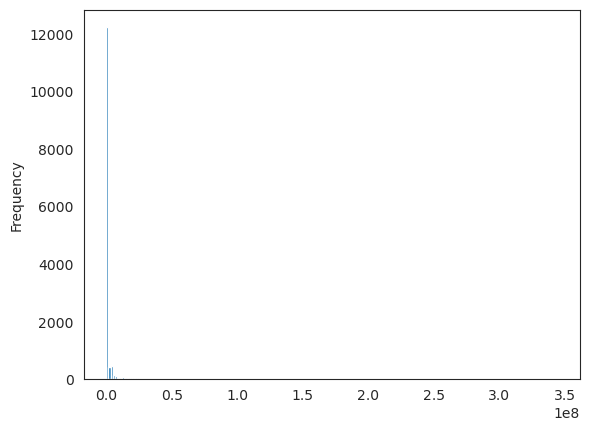

In [23]:
joined_2022.shape_Area.plot.hist(bins=200)

/tmp/ipykernel_793783/3212935917.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  joined_2022.area


<Axes: ylabel='Frequency'>

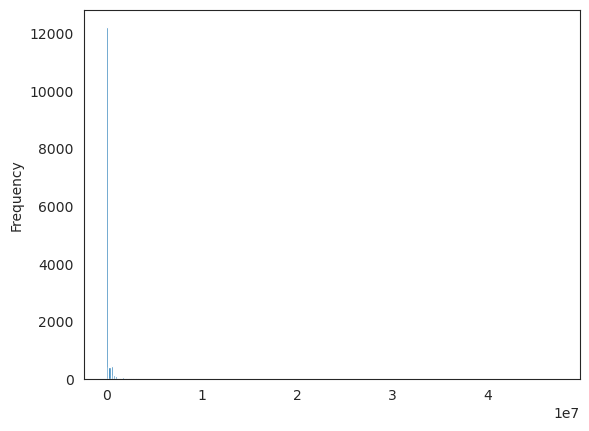

In [24]:
type(joined_2022)
joined_2022.area

joined_2022 = joined_2022.to_crs(3857)

# Create the plot
joined_2022.area.plot.hist(bins=200)
